# Telecom Customer Churn Analysis

This notebook demonstrates **Exploratory Data Analysis (EDA)**, feature engineering, modeling, and churn probability scoring on the provided dataset `telecom_churn.csv`.

Steps covered:
1. Load dataset
2. Data Cleaning & Exploration
3. Visualizations (EDA)
4. Feature Engineering
5. Model Training (Random Forest)
6. Model Evaluation (ROC, Precision@K)
7. Feature Importance
8. Export churn scores for dashboard


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import joblib

In [17]:
# Load dataset (replace path with your local file path if needed)
df = pd.read_csv('/content/drive/MyDrive/dataset/telecom_churn.csv')
df.head()

,customer_id,gender,seniority_months,contract_type,internet_service,monthly_charges,num_complaints,paperless_billing,payment_method,total_charges,churn
0,CUST10000,Male,117,Month-to-month,NaN,91.03,0,No,Mailed check,10305.04,1
1,CUST10001,Female,62,One year,DSL,95.65,0,Yes,Credit card,5797.58,0
2,CUST10002,Male,16,One year,Fiber optic,77.92,0,Yes,Electronic check,1182.46,0
3,CUST10003,Male,72,One year,DSL,59.19,0,Yes,Electronic check,4623.49,0
4,CUST10004,Male,32,Month-to-month,DSL,84.20,0,Yes,Mailed check,2706.12,0


**Data Overview**

In [18]:
df.shape, df.info(), df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        1000 non-null   object 
 1   gender             1000 non-null   object 
 2   seniority_months   1000 non-null   int64  
 3   contract_type      1000 non-null   object 
 4   internet_service   847 non-null    object 
 5   monthly_charges    1000 non-null   float64
 6   num_complaints     1000 non-null   int64  
 7   paperless_billing  1000 non-null   object 
 8   payment_method     1000 non-null   object 
 9   total_charges      1000 non-null   float64
 10  churn              1000 non-null   int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 86.1+ KB


((1000, 11),
 None,
 customer_id            0
 gender                 0
 seniority_months       0
 contract_type          0
 internet_service     153
 monthly_charges        0
 num_complaints         0
 paperless_billing      0
 payment_method         0
 total_charges          0
 churn                  0
 dtype: int64)

**Exploratory Data Analysis**

Overall churn rate: 0.2


/tmp/ipython-input-3127092428.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='contract_type', y='churn', ci=None, ax=axes[0,0])


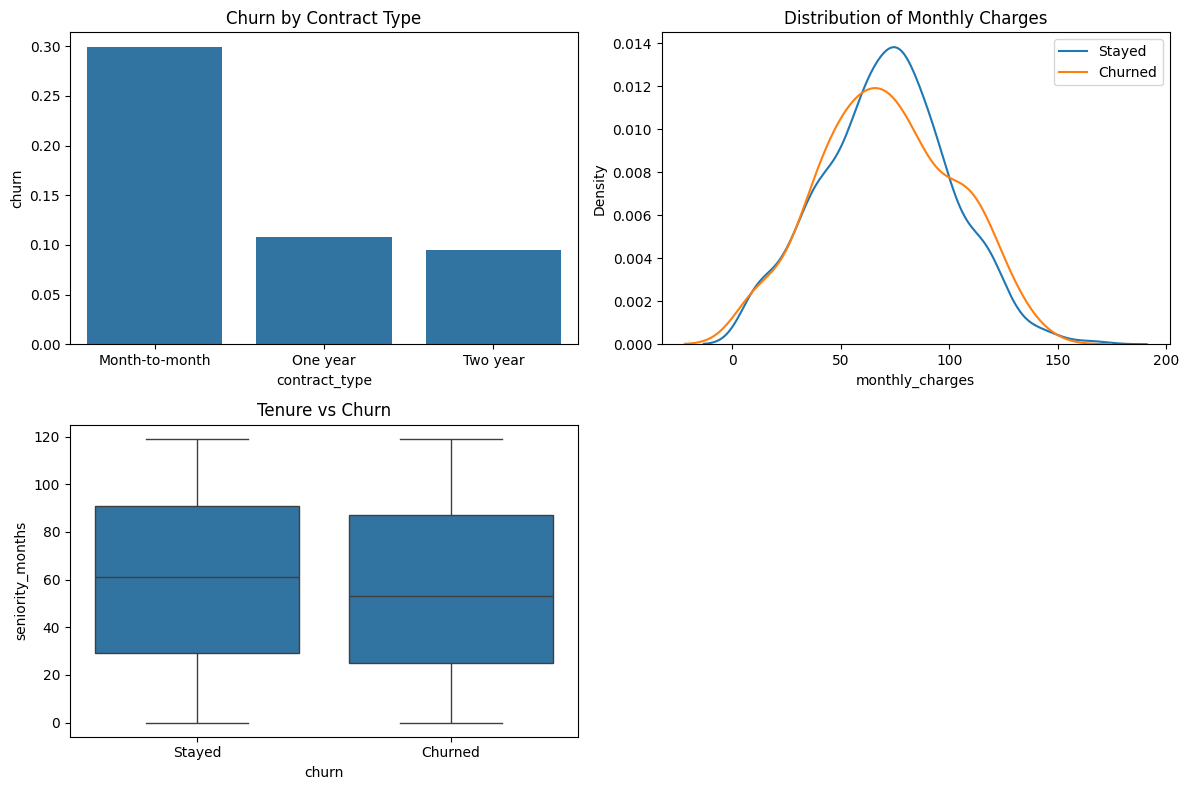

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Overall churn rate (just text output, no plot)
print('Overall churn rate:', df['churn'].mean())

# 1. Churn by contract type
sns.barplot(data=df, x='contract_type', y='churn', ci=None, ax=axes[0,0])
axes[0,0].set_title('Churn by Contract Type')

# 2. Distribution of monthly charges
sns.kdeplot(df.loc[df.churn==0,'monthly_charges'], label='Stayed', ax=axes[0,1])
sns.kdeplot(df.loc[df.churn==1,'monthly_charges'], label='Churned', ax=axes[0,1])
axes[0,1].legend()
axes[0,1].set_title('Distribution of Monthly Charges')

# 3. Tenure vs churn (full width)
sns.boxplot(data=df, x='churn', y='seniority_months', ax=axes[1,0])
axes[1,0].set_xticks([0,1])
axes[1,0].set_xticklabels(['Stayed','Churned'])
axes[1,0].set_title('Tenure vs Churn')

# Remove empty subplot (bottom right)
fig.delaxes(axes[1,1])

plt.tight_layout()
plt.show()


**Feature Engineering**

In [20]:
# Define numeric and categorical features
num_features = ['monthly_charges','total_charges','seniority_months','num_complaints']
cat_features = ['gender','contract_type','internet_service','paperless_billing','payment_method']
X = df[num_features + cat_features]
y = df['churn']
X.head()

,monthly_charges,total_charges,seniority_months,num_complaints,gender,contract_type,internet_service,paperless_billing,payment_method
0,91.03,10305.04,117,0,Male,Month-to-month,NaN,No,Mailed check
1,95.65,5797.58,62,0,Female,One year,DSL,Yes,Credit card
2,77.92,1182.46,16,0,Male,One year,Fiber optic,Yes,Electronic check
3,59.19,4623.49,72,0,Male,One year,DSL,Yes,Electronic check
4,84.20,2706.12,32,0,Male,Month-to-month,DSL,Yes,Mailed check


**Train-Test Split & Preprocessing**

In [21]:
import sklearn
from packaging import version
from sklearn.preprocessing import OneHotEncoder
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', ohe, cat_features)
])


**Model Training**

In [22]:
clf = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88       160
           1       0.42      0.12      0.19        40

    accuracy                           0.79       200
   macro avg       0.62      0.54      0.54       200
weighted avg       0.73      0.79      0.74       200

ROC AUC: 0.6235156249999999


**Feature Importance**

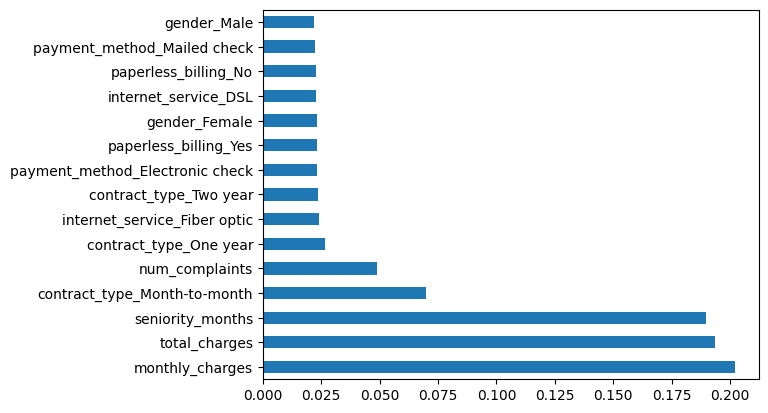

In [23]:
model = clf.named_steps['model']
ohe = clf.named_steps['prep'].named_transformers_['cat']
cat_names = list(ohe.get_feature_names_out(cat_features))
feature_names = num_features + cat_names
importances = pd.Series(model.feature_importances_, index=feature_names)
importances.sort_values(ascending=False).head(15).plot(kind='barh'); plt.show()

**Export churn scores for dashboard**

In [25]:
output.to_csv("churn_scores_for_dashboard.csv", index=False)
joblib.dump(clf, "rf_pipeline.joblib")

['rf_pipeline.joblib']

In [26]:
from google.colab import files

files.download("churn_scores_for_dashboard.csv")
files.download("rf_pipeline.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>